In [4]:
import pandas as pd
import csv
from datetime import datetime

df = pd.read_csv("https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
parse_dates = ['Date'], index_col = ['Date'])

bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"}) 

2229 2229 558 558


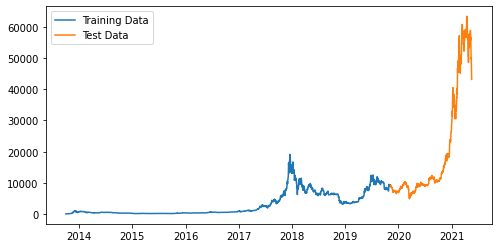

In [5]:
import matplotlib.pyplot as plt

'''
Splitting data into training and testing sets
-> using split_size function is the correct method
'''
timesteps = df.index.to_numpy()
prices = df['Closing Price (USD)'].to_numpy()

split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

print(len(X_train), len(y_train), len(X_test), len(y_test))

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(X_train, y_train, label = "Training Data")
ax.plot(X_test, y_test, label = "Test Data")
ax.legend()

def plot_time_series(timesteps, prices, start = 0, end = None):
    fig, ax = plt.subplots(figsize = (10, 7))
    ax.plot(timesteps[start:end], prices[start:end])
    plt.legend()

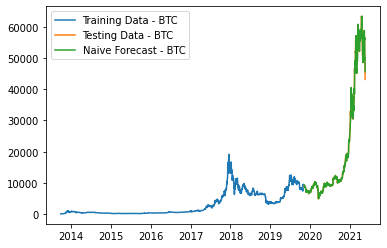

In [6]:
'''
Naive-Forecast -> Uses the previous timestep value to predict the next
'''
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[10:]

fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(X_train, y_train, label = "Training Data - BTC")
ax.plot(X_test, y_test, label = "Testing Data - BTC")
ax.plot(X_test[1:], naive_forecast, label = "Naive Forecast - BTC")
ax.legend()

In [7]:
'''
Evaluating Time Series Models
-> mae, mae, mse, rmse, mape
'''
import tensorflow as tf

def mean_abs_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mae_naive = tf.reduce_mean(tf.abs(y_true[1:] - y_test[:-1]))
    return mae / mae_naive

def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype = "float32")
    y_pred = tf.cast(y_pred, dtype = "float32")

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) 
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

naive_results = evaluate_preds(y_true = y_test[1:], y_pred = naive_forecast)
print(naive_results)

tf.reduce_mean(y_test).numpy()

{'mae': 567.9802, 'mse': 1147547.0, 'rmse': 1071.2362, 'mape': 2.516525}


20056.632963737226

In [8]:
'''
Windowing Algorithm -> Turns TS into supervised learning algorithm
e.g. -> univariate time series windowing for one week = 7
'''
import tensorflow as tf
import numpy as np

HORIZON, WINDOW_SIZE = 1, 7

def get_labelled_window(x, horizon = 1):
    return x[:, :-horizon], x[:, -horizon:]

test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8) + 1, axis = 0), horizon = HORIZON)

def get_labelled_windows(x, horizon = 1):
    return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size = 7, horizon = 1):
    window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis = 0).T
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array)
    return windows, labels

full_windows, full_labels = make_windows(prices, window_size = 7, horizon = 1)
len(full_windows), len(full_labels)

for i in range(3):
    print("Window: {}".format(full_windows[i]), "Labels: {}".format(full_labels[i]))

def create_train_test(windows, labels, test_split = 0.2):
    split_size = int((1-test_split) * len(windows))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]

    test_windows = windows[split_size:]
    test_labels = windows[split_size:]
    return train_windows, train_labels, test_windows, test_labels

train_windows, train_labels, test_windows, test_labels = create_train_test(full_windows, full_labels, test_split = 0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] Labels: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] Labels: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] Labels: [125.96116]


(2224, 556, 2224, 556)

In [9]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name), 
                                            verbose = 0, 
                                            save_best_only = True) 

inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) 
x = tf.keras.layers.LSTM(128, activation="relu", return_sequences=True)(x) 
x = tf.keras.layers.LSTM(128, activation="relu")(x) 
x = tf.keras.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.Dense(HORIZON)(x)
model_lstm = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm")

model_lstm.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_lstm.fit(train_windows, train_labels, epochs=100, verbose=0, batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name = model_lstm.name)])

INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets


In [10]:
model_lstm.summary()

Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 1, 7)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 128)            69632     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 205,377
Trainable params: 205,377
Non-trainable params: 0
__________________________________________________

In [17]:
model_lstm = tf.keras.models.load_model("model_experiments/model_lstm/")
model_lstm.evaluate(test_windows, test_labels)

def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

model_lstm_preds = make_preds(model_lstm, test_windows)
model_lstm_preds[:10]

18/18 [==============================] - 0s 1ms/step - loss: 639.2234


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9202.607, 9101.764, 9130.47 , 9013.642, 8927.367, 8909.47 ,
       8782.181, 8715.845, 8705.006, 8618.552], dtype=float32)>

In [9]:
model_lstm_preds = np.array(model_lstm_preds)

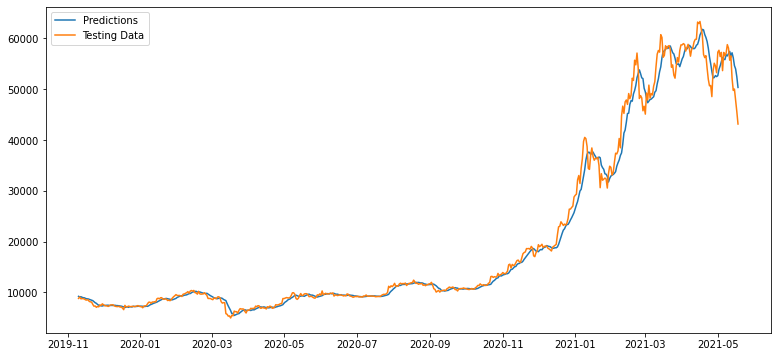

In [22]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(X_test[2:], model_lstm_preds, label = "Predictions")
ax.plot(X_test[2:], y_test[2:], label = "Testing Data")
ax.legend()